In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
import re
import subprocess
from pathlib import Path
from typing import List, Optional

import openvino as ov
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

import nncf

import random
# import torch
# from torchvision import transforms
# from torch.utils.data import TensorDataset, DataLoader
# from tensorflow.keras.utils import to_categorical

In [5]:
# pip install nncf

In [1]:
import cv2
import os
import numpy as np

def load_and_preprocess_data(path):
    X = []
    Y = []

    # 각 레이블에 대한 이미지를 불러오고 전처리
    for label in ('bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'):
        print("레이블 " + label + "이미지 로딩중.")

        label_path = os.path.join(path, label)
        if not os.path.isdir(label_path):
            print(f"디렉토리가 없음: {label_path}")
            continue

        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            img = cv2.imread(file_path)

            if img is None:
                print(f"이미지가 없음: {file_path}")
                continue

            # 이미지 크기 조정 (224x224로 리사이즈)
            img = cv2.resize(img, (224, 224))
            X.append(img)
            Y.append(['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'].index(label))

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 데이터를 불러올 디렉토리 경로를 지정해주세요.
data_path = 'C:\\Users\\MyoengHo Shin\\Desktop\\kfood'
X_train, y_train = load_and_preprocess_data(os.path.join(data_path, 'train'))
X_val, y_val = load_and_preprocess_data(os.path.join(data_path, 'val'))

레이블 bs의 이미지를 불러오는 중입니다.
레이블 kcbkb의 이미지를 불러오는 중입니다.
레이블 meetsushi의 이미지를 불러오는 중입니다.
레이블 pizza의 이미지를 불러오는 중입니다.
레이블 pumpkin의 이미지를 불러오는 중입니다.
레이블 spicypolk의 이미지를 불러오는 중입니다.
레이블 sushi의 이미지를 불러오는 중입니다.
레이블 tbk의 이미지를 불러오는 중입니다.
레이블 zb의 이미지를 불러오는 중입니다.
레이블 zzm의 이미지를 불러오는 중입니다.
레이블 bs의 이미지를 불러오는 중입니다.
레이블 kcbkb의 이미지를 불러오는 중입니다.
레이블 meetsushi의 이미지를 불러오는 중입니다.
레이블 pizza의 이미지를 불러오는 중입니다.
레이블 pumpkin의 이미지를 불러오는 중입니다.
레이블 spicypolk의 이미지를 불러오는 중입니다.
레이블 sushi의 이미지를 불러오는 중입니다.
레이블 tbk의 이미지를 불러오는 중입니다.
레이블 zb의 이미지를 불러오는 중입니다.
레이블 zzm의 이미지를 불러오는 중입니다.


In [4]:
# 데이터 정규화
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# 데이터 증강 설정 (학습 데이터셋에만 적용)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [5]:
# 데이터를 8:2로 나누어 학습 데이터와 검증 데이터로 사용
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 레이블을 원-핫 인코딩으로 변환
y_train_encoded = to_categorical(y_train_split)
y_val_encoded = to_categorical(y_val_split)

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# MobileNetV2 모델 불러오기
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# 모델 커스터마이징
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')  
])

In [7]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 3579978 (13.66 MB)
Trainable params: 3545866 (13.53 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Epoch
history = model.fit(datagen.flow(X_train_split, y_train_encoded, batch_size=32),
                    steps_per_epoch=len(X_train_split) / 32,
                    epochs=30,
                    validation_data=(datagen.flow(X_val_split, y_val_encoded, batch_size=32)))

Epoch 1/30
197/197 [==============================] - 434s 2s/step - loss: 0.8562 - accuracy: 0.7351 - val_loss: 19.8924 - val_accuracy: 0.0919
Epoch 2/30
197/197 [==============================] - 394s 2s/step - loss: 0.5725 - accuracy: 0.8214 - val_loss: 16.9117 - val_accuracy: 0.1148
Epoch 3/30
197/197 [==============================] - 394s 2s/step - loss: 0.4183 - accuracy: 0.8698 - val_loss: 15.3709 - val_accuracy: 0.0926
Epoch 4/30
197/197 [==============================] - 408s 2s/step - loss: 0.3915 - accuracy: 0.8810 - val_loss: 24.8858 - val_accuracy: 0.1129
Epoch 5/30
197/197 [==============================] - 405s 2s/step - loss: 0.3903 - accuracy: 0.8741 - val_loss: 10.3058 - val_accuracy: 0.1972
Epoch 6/30
197/197 [==============================] - 397s 2s/step - loss: 0.3221 - accuracy: 0.9018 - val_loss: 16.0189 - val_accuracy: 0.1585
Epoch 7/30
197/197 [==============================] - 387s 2s/step - loss: 0.2748 - accuracy: 0.9144 - val_loss: 18.8808 - val_accuracy:

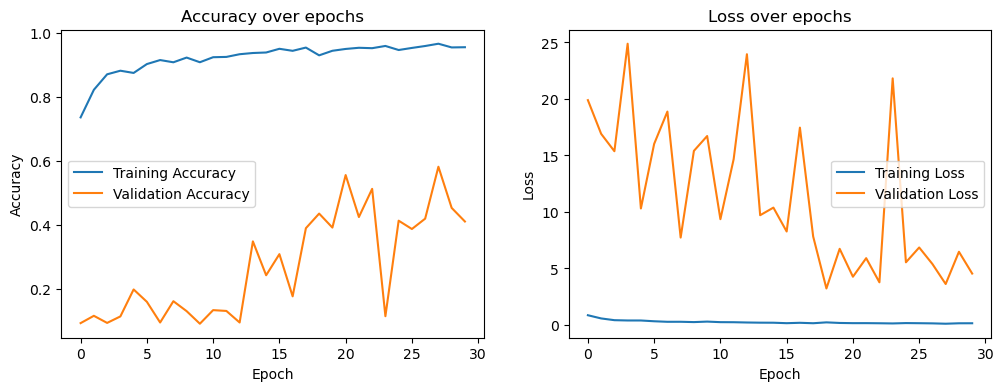

In [9]:
# Epoch별 train/val accuracy와 Loss변화

import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [11]:
# Train_acc, Train_Loss, val_acc, val_loss 출력
# test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
# print(f"Test Accuracy: {test_accuracy}")
# print(f"Test Loss: {test_loss}")

train_loss, train_accuracy = model.evaluate(X_train_split, y_train_encoded)
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_encoded)
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Loss: {train_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

50/50 [==============================] - 19s 376ms/step - loss: 5.1681 - accuracy: 0.3989
Train Accuracy: 0.39492467045783997
Train Loss: 4.981894493103027
Validation Accuracy: 0.39885860681533813
Validation Loss: 5.168086051940918


## 평가 및 시각화


50/50 [==============================] - 22s 411ms/step


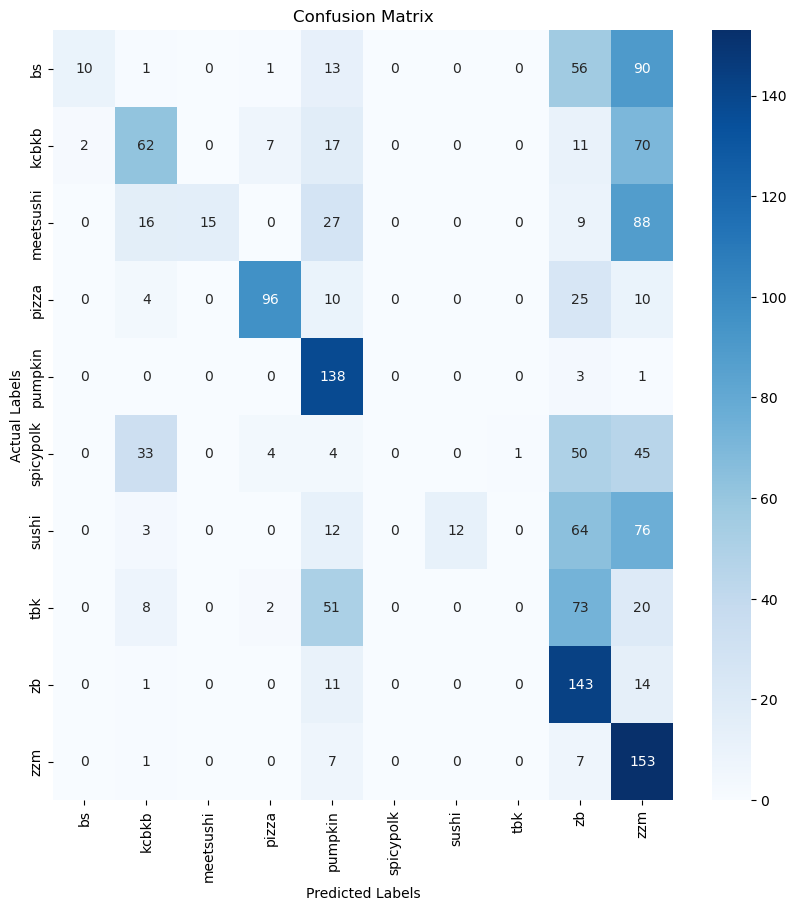

In [14]:
# 평가지표 - 혼동행렬
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

y_pred = model.predict(X_val_split)  # X_val_split을 사용
y_pred_classes = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_val_split, y_pred_classes, classes=['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'])

In [15]:
# 평가지표
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'])
    print(report)

print_classification_report(y_val_split, y_pred_classes)  # y_val_split을 사용

              precision    recall  f1-score   support

          bs       0.83      0.06      0.11       171
       kcbkb       0.48      0.37      0.42       169
   meetsushi       1.00      0.10      0.18       155
       pizza       0.87      0.66      0.75       145
     pumpkin       0.48      0.97      0.64       142
   spicypolk       0.00      0.00      0.00       137
       sushi       1.00      0.07      0.13       167
         tbk       0.00      0.00      0.00       154
          zb       0.32      0.85      0.47       169
         zzm       0.27      0.91      0.42       168

    accuracy                           0.40      1577
   macro avg       0.53      0.40      0.31      1577
weighted avg       0.53      0.40      0.31      1577



c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#모델용량 및 추론시간
import time
import os
import tensorflow.keras.backend as keras
import shutil
import time
import numpy as np 

def get_folder_size(folder):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def get_model_size(model):
    model.save("temp_model")
    size = os.path.getsize("temp_model") / (1024 * 1024)  # Convert bytes to MB
    shutil.rmtree('temp_model')  # 디렉토리와 내용을 모두 삭제
    return size

def predict_time(model, sample):
    start = time.time()
    model.predict(sample)
    end = time.time()
    return end - start

# 모델 사이즈
model_size = get_model_size(model)
print(f"Model size: {model_size:.2f} MB")

# 샘플당 추론 시간
sample_inference_time = predict_time(model, np.expand_dims(X_val_split[0], axis=0))
print(f"Sample inference time: {sample_inference_time:.4f} seconds")

INFO:tensorflow:Assets written to: temp_model\assets


INFO:tensorflow:Assets written to: temp_model\assets


Model size: 0.00 MB
1/1 [==============================] - 0s 41ms/step
Sample inference time: 0.0791 seconds


2/2 [==============================] - 1s 197ms/step


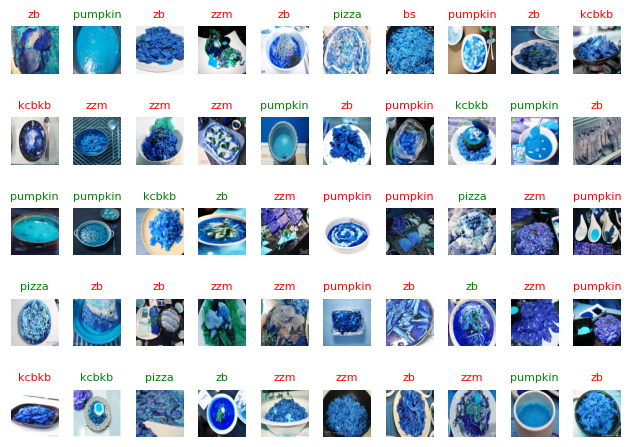

Accuracy on the sampled images: 32.00%


In [18]:
classes = ['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm']

# 검증 데이터셋에서 무작위로 50장 선택
num_samples = 50
random_indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[random_indices]
sample_labels = y_val[random_indices]

# 예측 수행
predicted_labels = np.argmax(model.predict(sample_images), axis=1)

# 시각화
for i in range(num_samples):
    plt.subplot(5, 10, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    if sample_labels[i] == predicted_labels[i]:
        color = 'green'
    else:
        color = 'red'
    plt.title(classes[predicted_labels[i]], color=color, fontsize=8)

plt.tight_layout()
plt.show()

accuracy = np.sum(sample_labels == predicted_labels) / num_samples
print(f"Accuracy on the sampled images: {accuracy * 100:.2f}%")